In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy
from dataset import Dataset

In [2]:
def imshowCvt(ax, img):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [3]:
def plotWithColorBar(fig, ax, dat):
    im = ax.imshow(dat)
    fig.colorbar(im, ax=ax)

In [4]:
def drawCircle(ax, center, radius):
    ax.add_artist(plt.Circle(center, radius, color='r', fill=False))
    ax.plot(*center, 'r+')

# 常數

In [5]:
DATASET_PATH = 'dataset/bag/'
NUM_BIN = 8

載入資料集

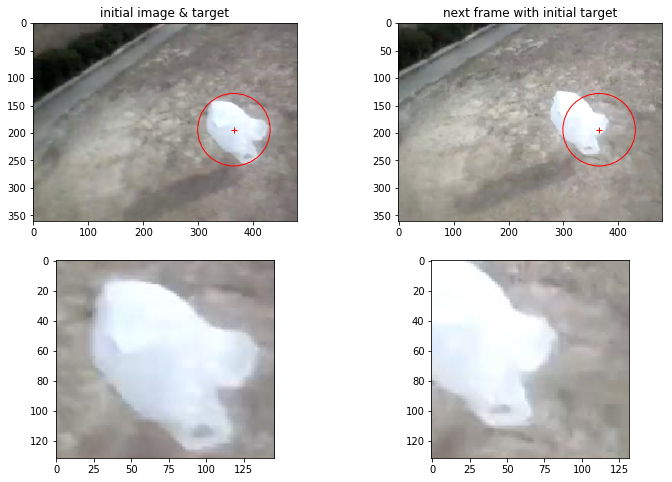

In [6]:
data = Dataset(DATASET_PATH)

# init
y0 = numpy.average(data.gtruth[0], 0).astype(int)
h = numpy.min(numpy.diff(data.gtruth[0], axis=0).astype(int))
h_2 = int(h/2)

# draw
_, ((axL, axR), (axI, axN)) = plt.subplots(2, 2, figsize=(12, 8))

axL.set_title('initial image & target')
imshowCvt(axL, data.imgs[0])
drawCircle(axL, y0, h_2)

axR.set_title('next frame with initial target')
imshowCvt(axR, data.imgs[1])
drawCircle(axR, y0, h_2)

target_initial = data.target(0)
imshowCvt(axI, target_initial)

target_next = data.imgs[1][y0[1]-h_2:y0[1]+h_2, y0[0]-h_2:y0[0]+h_2]
imshowCvt(axN, target_next)

plt.show()

# Kernel

原本的 epancechnikov profile
$$
k(x)=\begin{cases} 
    \frac{1}{2} c^{-1}_d (d+2) (1-x)   & x \leqq 1
    \\
    0 & otherwise
   \end{cases}
$$

本次計算中使用方式皆為 $K(x) = C k{({\|\frac{y-x}{h}\|})}$ 之形式，故改寫為
$$
K(x) = \begin{cases} 
    C(1-x^2)   & x \leqq 1
    \\
    0 & otherwise
   \end{cases}
\\
C = sum(K)
$$


In [7]:
def create_kernel(r, c):
    """
    create kernel with epancechnikov profile
    
    @param r, c: size
    """
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    C, R = numpy.meshgrid(cc, rr)
    X2 = C**2 + R**2
    
    kernel = numpy.maximum(1-X2, 0)
    return kernel / numpy.sum(kernel)

以下是這個kernel的長相

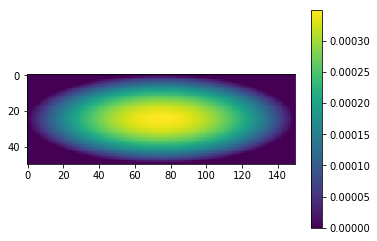

In [8]:
plt.imshow(create_kernel(50, 150))
plt.colorbar()
plt.show()

# $m$-bin histogram

此模型中將圖片以pdf方式表示，為了減少計算量，將資料收斂為 $m$-bin 的分布

In [9]:
BAND = 255 /NUM_BIN
def to_b_num(img):
    assert isinstance(img, numpy.ndarray)
    b = (img //BAND).astype(int)
    return numpy.minimum(b, 7)

# Target model

在每一個frame中會將圖片的pdf以kernel進行轉換

$$
\hat{q}_u = C \sum^n_{i=1}{
    k({\|x^*_i\|^2})
    \delta
    [b(x^*_i)-u]
}
\tag{原式}
$$

而上述流程中已經將kernel $k(x)$ 轉換為 $K(x) = C k{({\|\frac{y-x}{h}\|})}$ 之形式，故代換為
$$
\hat{q}_u = \sum^n_{i=1}{
    K({\|x^*_i\|})
    \delta
    [b(x^*_i)-u]
}
$$

其中
1. $u$ 是對應到底幾個bin
2. $x^*_i$ 是正規化到$[0, 1]$的座標
3. $b(x)$ 是該座標對應的bin
4. $\delta$ 是[Kronecker delta function](https://en.wikipedia.org/wiki/Kronecker_delta)，即為內積

In [10]:
def create_target_model(target_img):
    B = to_b_num(target_img)
    
    kernel = create_kernel(*target_img.shape[:2])
    
    M = numpy.empty((NUM_BIN, 3))
    for b in range(NUM_BIN):
        for ch in range(3):
            M[b, ch] = numpy.sum(kernel[B[:,:,ch]==b])
            
    return M

對於一個輸入的圖片可將其轉換為一個target model，下圖縱軸為bin，橫軸為channel

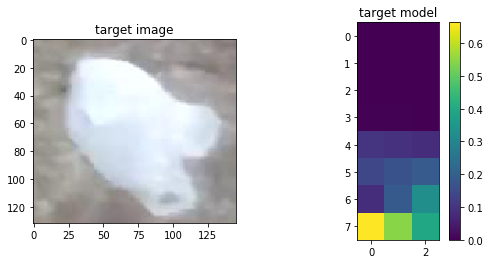

In [11]:
q0 = create_target_model(data.target(0))

#
fig, (axL, axR) = plt.subplots(1, 2, figsize=(8, 4))

axL.set_title('target image')
imshowCvt(axL, target_initial)

axR.set_title('target model')
plotWithColorBar(fig, axR, q0)

plt.show()

# Target Candidate

同target model之流程，將下個frame的圖片也轉成一個target candidate model來進行運算

In [12]:
def create_target_candidate(img, center, diameter):
    """
    @param orig_img  the entire img
    @param num_bin   the num of hist bins
    @param center    center (x, y)
    @param diameter  mask diameter, aka normalized factor
    """
    R, C = img.shape[:2]
    
    c, r = center
    c = int(c)
    r = int(r)
    
    radius = int(min(diameter/2, R-r, C-c))
    
    target_img = img[r-radius:r+radius, c-radius:c+radius]
    return create_target_model(target_img)

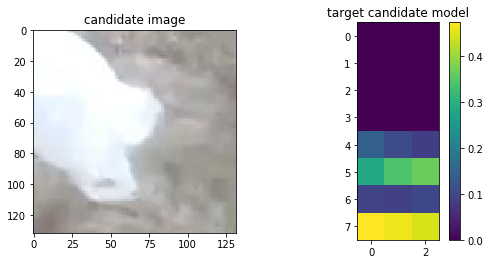

In [13]:
test_tc = create_target_candidate(data.imgs[1], y0, h)

#
fig, (axL, axR) = plt.subplots(1, 2, figsize=(8, 4))

axL.set_title('candidate image')
imshowCvt(axL, target_next)

axR.set_title('target candidate model')
plotWithColorBar(fig, axR, test_tc)

plt.show()

# Bhattacharyya Coefficient

論文中定義兩個分布間的距離為
$$
d(y) = \sqrt{
    1 - \rho\left[{
        \hat{p}(y) - \hat{q}
    }\right]
}
\tag{1}
$$

其中
$$
\hat{\rho}(y) 
    \equiv \rho\left[{
        \hat{p}(y) - \hat{q}
    }\right]
    = \sum^m_{u=1}{\sqrt{
        \hat{p}_u(y) \hat{q}_u
    }}
$$

即來自[Bhattacharyya Coefficient](https://en.wikipedia.org/wiki/Bhattacharyya_distance)

要追蹤物體則我們需要最小化Bhattacharyya Coefficient，根據文中的推導，最小化距離(1)可導向最大化下式(2)
$$
\rho\left[{
        \hat{p}(y) - \hat{q}
    }\right]
\approx
\frac{1}{2}\sum\sqrt{\hat{p}_u(\hat{y}_0)\hat{q}_u}
+
\frac{C_h}{2}\sum{w_i k\left({
    \left\| \frac{y-x_i}{h} \right\|
}^2 \right)}
\tag{2}
$$

其中
$$
w_i = \sum^m_{u=1}{
    \sqrt{\frac{ \hat{q}_u }{ \hat{p}_u(\hat{y}_0) }}
} \delta [ b(x_i) -u ]
$$

在每個frame的計算中$y_0$, $q$不會變動，故 $\hat{p}(\hat{y}_0)\hat{q}$ 基本上相當於一個常數；因此計算的重點是 $w$，以下進行計算

In [14]:
def calc_weight(img, target_model, target_candidate, center, diameter):
    assert isinstance(center, numpy.ndarray)
    
    # pre-calculate weight coef
    C = numpy.zeros((NUM_BIN, 3))
    idx = target_candidate > 0
    C[idx] = numpy.sqrt(target_model[idx] / target_candidate[idx])
    
    # estimate range
    diameter = int(diameter)

    cnr_c, cnr_r = center.astype(int) - (diameter >> 1)
    target_img = to_b_num(img[cnr_r:cnr_r+diameter, cnr_c:cnr_c+diameter])

    #
    r, c, _ = target_img.shape
    weight = numpy.empty((r, c))
    for i in range(target_img.shape[0]):
        for j in range(target_img.shape[1]):
            b_val = target_img[i, j]
            
            c_val = 1.0
            for ch in range(3):
                c_val *= C[b_val[ch], ch]
            weight[i, j] = c_val
    
    # create G(X), derivation of kernel k(x)
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    
    C, R = numpy.meshgrid(cc, rr)
    G = (C**2 + R**2) < 1
    
    # apply mask G(X)
    density = weight *G
    density /= numpy.sum(density)
    
    return density

上面程式中除了計算完成$w$，亦把後續計算meanshift前要套用的mask加上去了，做為顯示之用

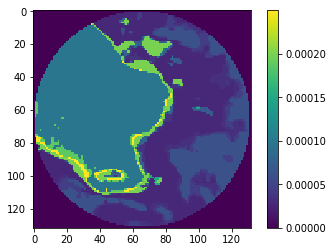

In [15]:
test_D = calc_weight(data.imgs[1], q0, test_tc, numpy.array([365, 194]), 132)

#
plt.imshow(test_D)
plt.colorbar()
plt.show()

# Meanshift

用meanshift決定要window要往哪邊移動

In [16]:
def meanshift(density):
    """
    a round of meanshift in the algorithm
    
    @param  weight weight of the target candidates
    @return        translation, in (x, y)
    """
    # create G(X), derivation of kernel k(x)
    r, c = density.shape
    
    rr = numpy.arange(r) / (r-1) *2 -1
    cc = numpy.arange(c) / (c-1) *2 -1
    
    C, R = numpy.meshgrid(cc, rr)
    
    # measure shift
    C *= density
    R *= density
    
    sft_c = numpy.sum(C) *c
    sft_r = numpy.sum(R) *r
    
    return int(sft_c), int(sft_r)
    

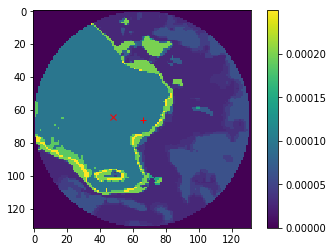

shift: -18, -2


In [17]:
x, y = meanshift(test_D)

#
fig, ax = plt.subplots()
plotWithColorBar(fig, ax, test_D)
ax.plot(h_2, h_2, 'r+')
ax.plot(h_2+x, h_2+y, 'rx')

plt.show()
print(f'shift: {x}, {y}')

# 結果

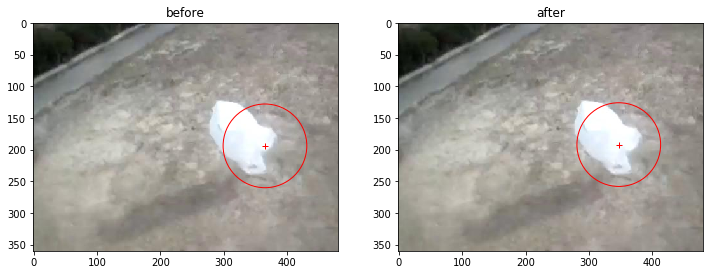

In [18]:
fig, (axL, axR) = plt.subplots(1, 2, figsize=(12, 6))

axL.set_title('before')
imshowCvt(axL, data.imgs[1])
drawCircle(axL, y0, h_2)

axR.set_title('after')
imshowCvt(axR, data.imgs[1])
drawCircle(axR, (y0[0]+x, y0[1]+y), h_2)

plt.show()

對所有frame重複以上流程直到完成